In [1]:
import tensorflow as tf
keras = tf.keras
import numpy as np
from IPython.display import Image, display
from matplotlib import pyplot as plt
from tensorflow.keras.models import load_model
import matplotlib.image as mpimg


In [2]:
last_conv_layer_name = "block14_sepconv1_act"

In [3]:
img_path = 'tigre.png'

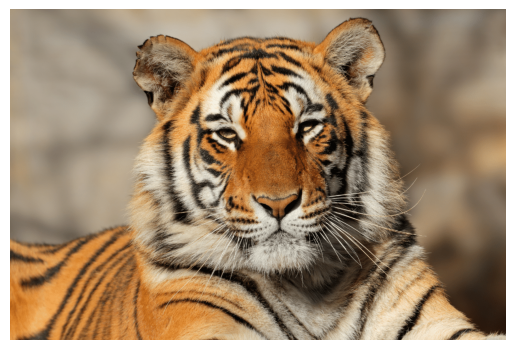

In [4]:
# Cargar y mostrar la imagen
img = mpimg.imread(img_path)
plt.imshow(img)
plt.axis('off')  # Para ocultar los ejes
plt.show()

In [5]:
def get_img_array(img_path, size):
    # `img` is a PIL image of size 299x299
    img = keras.utils.load_img(img_path, target_size=size)
    # `array` is a float32 Numpy array of shape (299, 299, 3)
    array = keras.utils.img_to_array(img)
    # We add a dimension to transform our array into a "batch"
    # of size (1, 299, 299, 3)
    array = np.expand_dims(array, axis=0)
    return array

In [6]:
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = keras.models.Model(
        model.inputs, [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

In [7]:
model_builder = keras.applications.xception.Xception

# Make model
model = model_builder(weights="imagenet")

# Remove last layer's softmax
model.layers[-1].activation = None

91884032/91884032 ━━━━━━━━━━━━━━━━━━━━ 14s 0us/step


In [8]:
model.summary()

Model: "xception"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 299, 299,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1        │ (None, 149, 149,  │        864 │ input_layer[0][0] │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1_bn     │ (None, 149, 149,  │        128 │ block1_conv1[0][… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1_act    │ (None, 149, 149,  │          0 │ block1_conv1_bn[… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2        │ (None, 147, 147,  │     18,432 │ block1_conv1_act… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2_bn     │ (None, 147, 147,  │        256 │ block1_conv2[0][… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2_act    │ (None, 147, 147,  │          0 │ block1_conv2_bn[… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv1     │ (None, 147, 147,  │      8,768 │ block1_conv2_act… │
│ (SeparableConv2D)   │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv1_bn  │ (None, 147, 147,  │        512 │ block2_sepconv1[… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv2_act │ (None, 147, 147,  │          0 │ block2_sepconv1_… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv2     │ (None, 147, 147,  │     17,536 │ block2_sepconv2_… │
│ (SeparableConv2D)   │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv2_bn  │ (None, 147, 147,  │        512 │ block2_sepconv2[… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 74, 74,    │      8,192 │ block1_conv2_act… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_pool         │ (None, 74, 74,    │          0 │ block2_sepconv2_… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 74, 74,    │        512 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 74, 74,    │          0 │ block2_pool[0][0… │
│                     │ 128)              │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_sepconv1_act │ (None, 74, 74,    │          0 │ add[0][0]       

 Total params: 22,910,480 (87.40 MB)

 Trainable params: 22,855,952 (87.19 MB)

 Non-trainable params: 54,528 (213.00 KB)

In [10]:
img_size = (299, 299)

In [11]:
preprocess_input = keras.applications.xception.preprocess_input
decode_predictions = keras.applications.xception.decode_predictions

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
35363/35363 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Predicted: [('n02129604', 'tiger', 8.985223)]


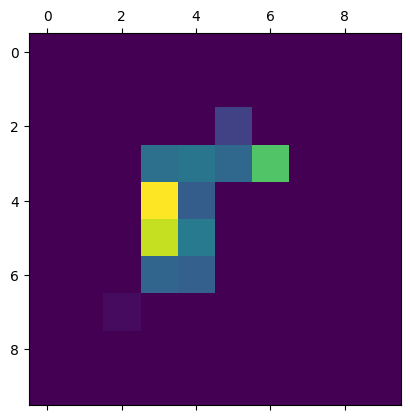

In [13]:
img_path = 'tigre.png'
img_array = preprocess_input(get_img_array(img_path, size=img_size))

# Print what the top predicted class is
preds = model.predict(img_array)
print("Predicted:", decode_predictions(preds, top=1)[0])

# Generate class activation heatmap
heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)

# Display heatmap
plt.matshow(heatmap)
plt.show()

C:\Users\48521682\AppData\Local\Temp\ipykernel_20988\2670776325.py:10: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  jet = plt.cm.get_cmap("jet")
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.009411764798649386..1.320000020312328].


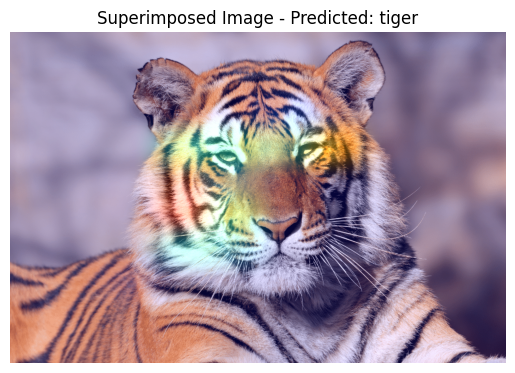

In [14]:
# Superpose the heatmap on original image

# Load the original image
img = keras.preprocessing.image.load_img(img_path)

# Rescale heatmap to a range 0-255
heatmap = np.uint8(255 * heatmap)

# Use jet colormap to colorize heatmap
jet = plt.cm.get_cmap("jet")

# Use RGB values of the colormap
jet_colors = jet(np.arange(256))[:, :3]

# Create an image with RGB colorized heatmap
jet_heatmap = jet_colors[heatmap]

# Create an image with RGB colorized heatmap
jet_heatmap = keras.preprocessing.image.array_to_img(jet_heatmap)
jet_heatmap = jet_heatmap.resize((img.size[0], img.size[1]))
jet_heatmap = keras.preprocessing.image.img_to_array(jet_heatmap) / 255

# Superimpose the heatmap on original image
superimposed_img = jet_heatmap * 0.4 + np.array(img) / 255

fig, ax = plt.subplots()

ax.imshow(superimposed_img)
ax.axis('off')
ax.set_title('Superimposed Image - Predicted: {}'.format(decode_predictions(preds, top=1)[0][0][1]))
plt.show()

In [15]:

def get_grad_heatmap(conv_layer_name):
    # Print what the top predicted class is
    preds = model.predict(img_array)
    print("Predicted:", decode_predictions(preds, top=1)[0])

    # Generate class activation heatmap
    heatmap = make_gradcam_heatmap(img_array, model, conv_layer_name)


    # Load the original image
    img = keras.preprocessing.image.load_img(img_path)

    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    jet = plt.cm.get_cmap("jet")

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]

    # Create an image with RGB colorized heatmap
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.size[0], img.size[1]))
    jet_heatmap = keras.preprocessing.image.img_to_array(jet_heatmap) / 255

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * 0.4 + np.array(img) / 255

    return superimposed_img


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 321ms/step
Predicted: [('n02129604', 'tiger', 8.985223)]


C:\Users\48521682\AppData\Local\Temp\ipykernel_20988\3109981628.py:17: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  jet = plt.cm.get_cmap("jet")
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.00784313725490196..1.3450980451761507].


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 383ms/step
Predicted: [('n02129604', 'tiger', 8.985223)]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.01568627450980392..1.3490196138036017].


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 355ms/step
Predicted: [('n02129604', 'tiger', 8.985223)]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.00784313725490196..1.3615686276379755].


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 330ms/step
Predicted: [('n02129604', 'tiger', 8.985223)]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.00784313725490196..1.3647058883134058].


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 285ms/step
Predicted: [('n02129604', 'tiger', 8.985223)]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.00784313725490196..1.3647058883134058].


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 310ms/step
Predicted: [('n02129604', 'tiger', 8.985223)]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.01568627450980392..1.3450980451761507].


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 251ms/step
Predicted: [('n02129604', 'tiger', 8.985223)]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.01568627450980392..1.3043137439325743].


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 300ms/step
Predicted: [('n02129604', 'tiger', 8.985223)]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.01568627450980392..1.290196084391837].


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 346ms/step
Predicted: [('n02129604', 'tiger', 8.985223)]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.01568627450980392..1.3137254980264925].


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 317ms/step
Predicted: [('n02129604', 'tiger', 8.985223)]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.00784313725490196..1.3615686276379755].


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 267ms/step
Predicted: [('n02129604', 'tiger', 8.985223)]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.00784313725490196..1.3647058883134058].


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 293ms/step
Predicted: [('n02129604', 'tiger', 8.985223)]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.01568627450980392..1.2792156878639669].


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 251ms/step
Predicted: [('n02129604', 'tiger', 8.985223)]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.00784313725490196..1.3341176477133059].


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 308ms/step
Predicted: [('n02129604', 'tiger', 8.985223)]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.01568627450980392..1.286274515764386].


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 259ms/step
Predicted: [('n02129604', 'tiger', 8.985223)]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.01568627450980392..1.1843137314506604].


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 293ms/step
Predicted: [('n02129604', 'tiger', 8.985223)]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.00784313725490196..1.3647058883134058].


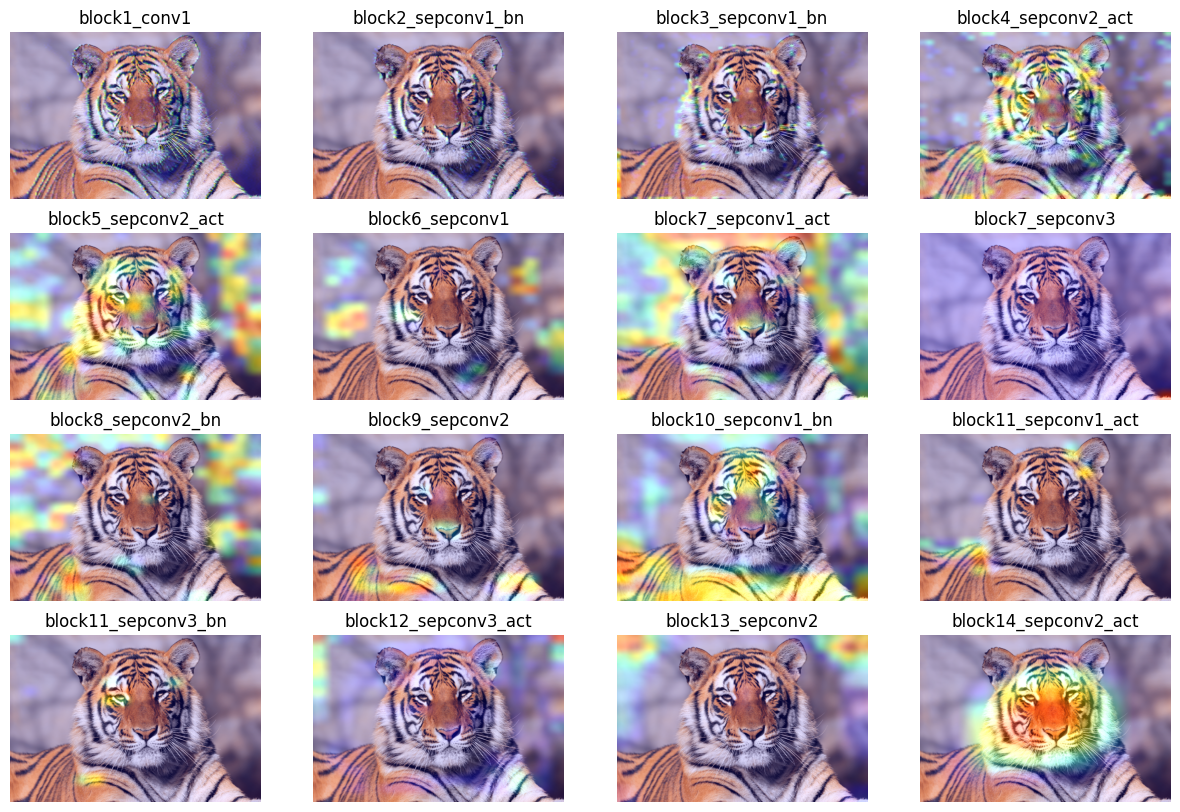

In [16]:
# Get all "*conv{n}_act" like layers in model
conv_layers = [layer.name for layer in model.layers if 'conv' in layer.name]
num_layers = len(conv_layers)

# Generar 16 índices únicos de manera uniforme
amm = 16
indices = np.linspace(0, num_layers - 1, amm, dtype=int)
fig, axes = plt.subplots(int(np.sqrt(amm)), int(np.sqrt(amm)), figsize=(15, 10))

for ax, i in zip(axes.flatten(), indices):
    heatmap = get_grad_heatmap(conv_layers[i])
    ax.imshow(heatmap)
    ax.axis('off')
    ax.set_title(conv_layers[i])